# ExoPredict-Data Analysis

# Pre-Processing


In [1]:
import os
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-3.5.4/spark-3.5.4-bin-hadoop3.tgz
!tar xf spark-3.5.4-bin-hadoop3.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.4-bin-hadoop3"

In [2]:
# Import findspark and initialise.
import findspark
findspark.init()

In [91]:
# Upload the file from Output->CSV_files->Cleaned Dataset
from google.colab import files
uploaded = files.upload()

Saving Cleaned Dataset.csv to Cleaned Dataset (1).csv


In [90]:
# Import packages
from pyspark.sql import SparkSession
import time

# Create a SparkSession
spark = SparkSession.builder.appName("ExoPlanet_ETL_Project").getOrCreate()

In [68]:
# Read the file
file_path = "Cleaned Dataset.csv"

df = spark.read.option("header", "true").option("inferSchema", "true").csv(file_path)
df.show(5)

+---------------+-------------+-----------+----------------+--------------+--------------------+--------------------+-------------------+--------------------------+--------------------------+------------------+-------------------+-------+-----------------+---------+------------+--------------------+--------+-----------------------+--------+--------+---------+--------+--------------------+-----------+------------------+------------+------------+----------+-----------------+---------------+----------------+--------------------+--------------------+------------+-----------+-----------+------------------+-----------------------+-------------------------+--------------+--------------------+--------------------+----------------------+------------------------+
|    Planet_Name|    Host_Star|Num_Planets|Discovery_Method|Discovery_Year|  Discovery_Facility|      Reference_Name|Orbital_Period_Days|Orbital_Period_Error_Upper|Orbital_Period_Error_Lower|Semi_Major_Axis_AU|Planet_Radius_Earth|pl_rad

In [69]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Create new columns based on calculations
df = df.withColumn("orb_id", col("Equilibrium_Temperature") + 2)
df = df.withColumn("cluster_id", col("Equilibrium_Temperature") * 2)
df = df.withColumn("disc_id", col("orb_id") + col("cluster_id"))
df = df.withColumn("thermo_id", col("Equilibrium_Temperature") * 5)

# Remove duplicate rows based on unique constraints
df = df.dropDuplicates(["orb_id"])
df = df.dropDuplicates(["cluster_id"])
df = df.dropDuplicates(["disc_id"])
df = df.dropDuplicates(["thermo_id"])


In [70]:
# Finding duplicate values based on a specific column (e.g., 'orb_id')
duplicate_orb_id_df = df.groupBy("orb_id").count().filter(col("count") > 1).drop("count")

# Show duplicate 'orb_id' rows
duplicate_orb_id_df.show()

+------+
|orb_id|
+------+
+------+



In [71]:
# Copy the dataset for future use
df_copy = df.cache()

#### Data Analysis
 1. **How do planetary characteristics influence the likelihood of being in the habitable zone? (Mandeep)**

 Answer: The habitable zone (HZ) depends on the semi-major axis (AU) and star temperature (K).
We'll classify planets as potentially habitable based on their distance from the star (semi-major axis) and the equilibrium temperature.

 We'll consider a planet inside the habitable zone if:
Semi-major axis (AU) falls within the range for a Sun-like star (0.38 - 1.5 AU).

 Equilibrium temperature falls between 200K and 320K.


In [12]:
# Import necessary libraries
from pyspark.sql.types import IntegerType, DoubleType, DateType
from pyspark.sql.functions import col, isnan, when, count, monotonically_increasing_id
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.clustering import KMeans
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


In [13]:
# Define habitable zone classification
df = df.withColumn("Habitable_Zone_Status",
    when((col("Semi_Major_Axis_AU").between(0.38, 1.5)) &
         (col("Equilibrium_Temperature").between(200, 320)),
         "Potentially Habitable").otherwise("Not Habitable"))

# Count habitable vs. non-habitable planets
df.groupBy("Habitable_Zone_Status").count().show()

+---------------------+-----+
|Habitable_Zone_Status|count|
+---------------------+-----+
|        Not Habitable|  634|
| Potentially Habit...|    7|
+---------------------+-----+



In [14]:
# Save habitable classification
df_habitable = df.select("Planet_Name", "Semi_Major_Axis_AU", "Equilibrium_Temperature", "Habitable_Zone_Status")
df_habitable = df_habitable.toPandas()
df_habitable.to_csv("habitability.csv", index=False)

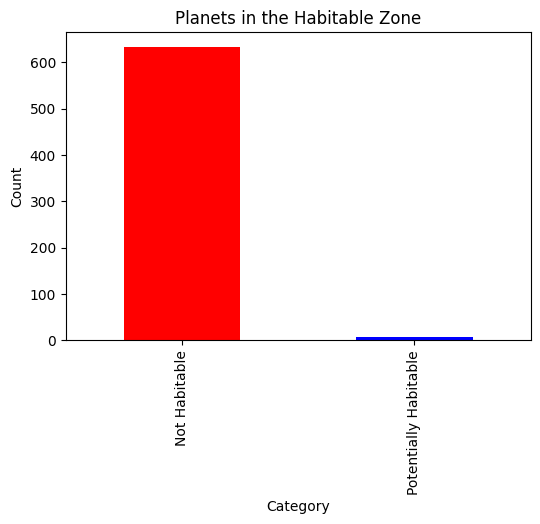

In [15]:
# Plot Habitable vs. Non-Habitable Planets
df.select("Habitable_Zone_Status").toPandas()["Habitable_Zone_Status"]
plt.figure(figsize=(6,4))
df_habitable["Habitable_Zone_Status"].value_counts().plot(kind='bar', color=['red', 'blue'])
plt.title("Planets in the Habitable Zone")
plt.xlabel("Category")
plt.ylabel("Count")
plt.savefig("habitable_vs_non_habitable_planets.png")
plt.show()

In [16]:
# Check and update the datatype for SQL Loading process
df_habitable.dtypes

,0
Planet_Name,object
Semi_Major_Axis_AU,float64
Equilibrium_Temperature,int32
Habitable_Zone_Status,object


2. How does a planet’s orbit impact its temperature and potential habitability?(Mandeep)

Answer: The orbital eccentricity and semi-major axis influence temperature variations. We will analyze how eccentric orbits lead to temperature fluctuations and impact habitability.

Highly eccentric orbits (e > 0.3) cause significant temperature fluctuations during different phases of orbit. We will compare eccentric vs. circular orbits to see how temperature variability impacts habitability.

In [55]:
#Analyze Orbital Eccentricity Impact on Temperature
#Classification: highly Eccentric:e >0.3, Circular/Stable: e < 0.3
df = df.withColumn("Orbit_Type",
    when(col("Orbital_Eccentricity") > 0.3, "Highly Eccentric").otherwise("Circular/Stable"))

# Show results
df.select("Planet_Name", "Orbital_Eccentricity", "Equilibrium_Temperature", "Orbit_Type","orb_id").show(10)

+----------------+--------------------+-----------------------+----------------+------+
|     Planet_Name|Orbital_Eccentricity|Equilibrium_Temperature|      Orbit_Type|orb_id|
+----------------+--------------------+-----------------------+----------------+------+
|       TOI-674 b|                 0.0|                    635| Circular/Stable|   637|
|     HIP 94235 b|                0.32|                   1060|Highly Eccentric|  1062|
|        HATS-8 b|               0.376|                   1324|Highly Eccentric|  1326|
|        NGTS-9 b|                0.06|                   1448| Circular/Stable|  1450|
|        NGTS-2 b|                 0.0|                   1468| Circular/Stable|  1470|
|    TOI-2803 A b|                 0.0|                   1893| Circular/Stable|  1895|
|     Kepler-22 b|                0.72|                    279|Highly Eccentric|   281|
|        K2-416 b| 0.09342613987473893|                    447| Circular/Stable|   449|
|        K2-141 c|              

In [56]:
 #Orbit Impact on Habitability ---
df_orbit = df.select("Planet_Name", "Orbital_Eccentricity", "Equilibrium_Temperature", "Orbit_Type","orb_id")
#Convert to Pandas for Visualisation
df_orbit_pd = df_orbit.toPandas()


In [57]:
df_orbit_pd.dtypes

,0
Planet_Name,object
Orbital_Eccentricity,float64
Equilibrium_Temperature,int32
Orbit_Type,object
orb_id,int32


In [58]:
df_orbit_pd.to_csv("OrbitalTemperature.csv", index=False)

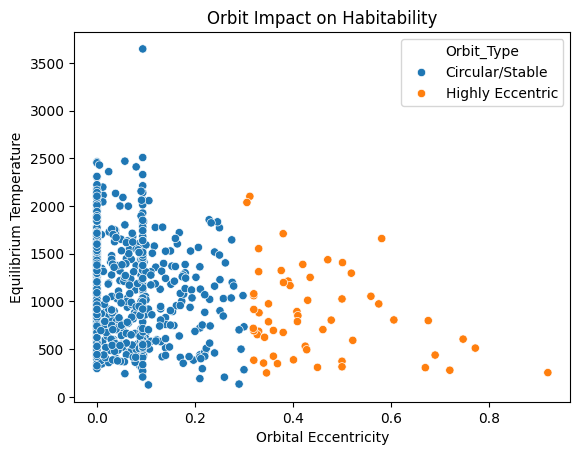

In [59]:

sns.scatterplot(data=df_orbit_pd, x='Orbital_Eccentricity', y='Equilibrium_Temperature', hue='Orbit_Type')
plt.xlabel("Orbital Eccentricity")
plt.ylabel("Equilibrium Temperature")
plt.title("Orbit Impact on Habitability")
plt.savefig("orbit_temperature_analysis.png")
plt.show()



Q1 & Q2: Classify planets by insolation, temperature, mass, coordinates with regards of available planets (Iaroslav)
Complete dataset, it'll be helpful to draw graphics with stars located across sphere (Iaroslav)

In [92]:
import sys
import os
sys.path.append(os.path.abspath("../ml_iaroslav"))
from rank_planets5 import planet_rank_by_similarity, plot_similarity_ranking

planet_name = "CoRoT-31 b"
ranks = planet_rank_by_similarity(planet_name, file_path="../Output/CSV_Files/Cleaned Dataset.csv", output_dir='../Output/CSV_Files', features=["Planet_Mass_Earth", "Equilibrium_Temperature", "ra"])
plot_similarity_ranking(rankings=ranks, reference_planet=planet_name, output_dir="../Output/Visualisations")

In [ ]:
import sys
import os
sys.path.append(os.path.abspath("../ml_iaroslav"))
from rank_stars import load_and_normalize_dataset, rank_by_similarity, plot_similarity_ranking

selected_star = "Kepler-107"  # Change this to any star in dataset
# Rank and plot stars by similarity to the selected star
X_normalized, df = load_and_normalize_dataset(file_path="../Output/CSV_Files/Cleaned Dataset.csv", output_dir='../Output/CSV_Files', features=['Star_Temperature_K', 'Star_Radius_Solar', 'Star_Mass_Solar'])
rankings = rank_by_similarity(X_normalized, selected_star, df)
plot_similarity_ranking(output_dir="../Output/Visualisations", rankings=rankings, reference_star=selected_star)

# Clustering
Question 1: Can we identify groups of similar exoplanets using clustering algorithms (e.g., K-means, hierarchical clustering) to group planets with similar characteristics.(Patrick)


In [24]:
df_copy.show(2)

+-----------+---------+-----------+----------------+--------------+--------------------+--------------------+-------------------+--------------------------+--------------------------+------------------+-------------------+-------+-----------------+---------+------------+--------------------+-----------------+-----------------------+--------+--------+---------+--------+--------------------+-----------+------------------+------------+------------+----------+-----------------+---------------+----------------+--------------------+--------------------+------------+-----------+-----------+------------------+-----------------------+-------------------------+--------------+------------------+--------------------+----------------------+------------------------+------+----------+-------+---------+
|Planet_Name|Host_Star|Num_Planets|Discovery_Method|Discovery_Year|  Discovery_Facility|      Reference_Name|Orbital_Period_Days|Orbital_Period_Error_Upper|Orbital_Period_Error_Lower|Semi_Major_Axis_AU

In [25]:
Planet= df_copy.select(['Planet_Name', 'Planet_Mass_Earth','Equilibrium_Temperature', 'pl_eqtlim','features','orb_id', 'cluster_id' ] )
Planet.show(2)

+-----------+-----------------+-----------------------+---------+------------------+------+----------+
|Planet_Name|Planet_Mass_Earth|Equilibrium_Temperature|pl_eqtlim|          features|orb_id|cluster_id|
+-----------+-----------------+-----------------------+---------+------------------+------+----------+
|  TOI-674 b|             23.6|                    635|        0|[5.25,23.6,3514.0]|   637|      1270|
|HIP 94235 b|            379.0|                   1060|        0|[3.0,379.0,5991.0]|  1062|      2120|
+-----------+-----------------+-----------------------+---------+------------------+------+----------+
only showing top 2 rows



In [27]:

# Define the features you want to include in the vector
features = ['Planet_Mass_Earth','Equilibrium_Temperature', 'pl_eqtlim']

# Create the VectorAssembler
vector_assembler = VectorAssembler(inputCols=features, outputCol='features_c')

# Apply the assembler to your dataframe
df_with_features = vector_assembler.transform(df_copy)

# Check the schema to ensure the 'features' column is a vector
df_with_features.printSchema()

# Now you can apply KMeans
from pyspark.ml.clustering import KMeans

# Apply KMeans clustering with the 'features' column
kmeans = KMeans(featuresCol='features_c', k=3)
model = kmeans.fit(df_with_features)

# Transform the data to assign each point to a cluster
df_clusters = model.transform(df_with_features)

# Show the results
df_clusters.select("Planet_Name", 'Planet_Mass_Earth','Equilibrium_Temperature', "pl_eqtlim", "prediction",'orb_id', 'cluster_id').show(10)



root
 |-- Planet_Name: string (nullable = true)
 |-- Host_Star: string (nullable = true)
 |-- Num_Planets: integer (nullable = true)
 |-- Discovery_Method: string (nullable = true)
 |-- Discovery_Year: integer (nullable = true)
 |-- Discovery_Facility: string (nullable = true)
 |-- Reference_Name: string (nullable = true)
 |-- Orbital_Period_Days: double (nullable = true)
 |-- Orbital_Period_Error_Upper: double (nullable = true)
 |-- Orbital_Period_Error_Lower: double (nullable = true)
 |-- Semi_Major_Axis_AU: double (nullable = true)
 |-- Planet_Radius_Earth: double (nullable = true)
 |-- pl_radj: double (nullable = true)
 |-- Planet_Mass_Earth: double (nullable = true)
 |-- pl_bmassj: double (nullable = true)
 |-- pl_bmassprov: string (nullable = true)
 |-- Orbital_Eccentricity: double (nullable = true)
 |-- pl_insol: double (nullable = true)
 |-- Equilibrium_Temperature: integer (nullable = true)
 |-- UEB_temp: integer (nullable = true)
 |-- LEB_temp: integer (nullable = true)
 |-- 

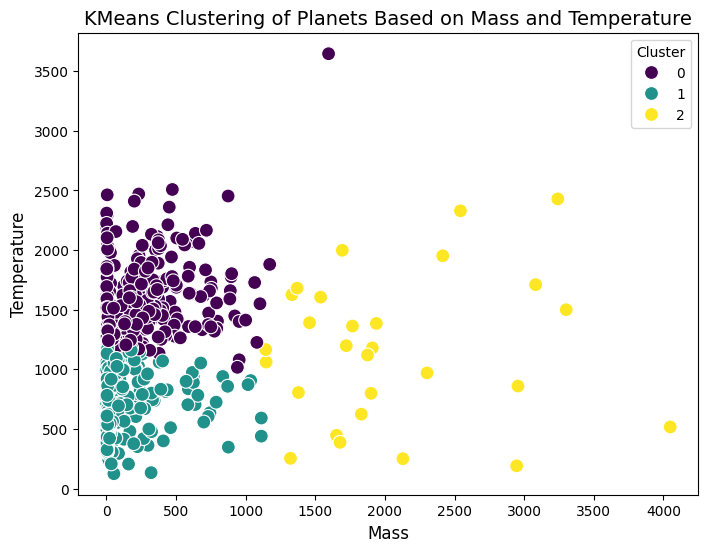

In [28]:
# Convert the cluster data to Pandas for plotting
df_clusters_pd = df_clusters.select("Planet_Name", 'Planet_Mass_Earth','Equilibrium_Temperature', "prediction",'orb_id', 'cluster_id').toPandas()


# Plotting the clusters
plt.figure(figsize=(8, 6))

# Scatter plot with color coding based on cluster prediction
sns.scatterplot(data=df_clusters_pd, x='Planet_Mass_Earth', y='Equilibrium_Temperature', hue='prediction', palette='viridis', s=100)

# Set plot titles and labels
plt.title('KMeans Clustering of Planets Based on Mass and Temperature', fontsize=14)
plt.xlabel('Mass', fontsize=12)
plt.ylabel('Temperature', fontsize=12)

# Display the plot
plt.legend(title='Cluster', loc='best')
plt.savefig("Clustering.png")
plt.show()


In [29]:
df_clusters_pd.to_csv("Clustering.csv", index=False)

In [30]:
df_clusters_pd.dtypes

,0
Planet_Name,object
Planet_Mass_Earth,float64
Equilibrium_Temperature,int32
prediction,int32
orb_id,int32
cluster_id,int32


## Analysis:

The clustering of exoplanets based on their mass, temperature, and equilibrium temperature (pl_eqtlim) has been performed using the K-Means algorithm, which categorizes planets into different clusters. The dataset shows planets divided into three clusters (0, 1, and 2), with cluster 2 containing most of the planets, including Kepler-138 c, TIC 139270665 b, and HD 136352 c. These planets share relatively moderate mass (ranging from 2.3 to 11.24) and a temperature range of 410–784 Kelvin.

On the other hand, cluster 0 includes TOI-3819 b, HAT-P-68 b, and TOI-6016 b, which exhibit significantly higher masses (ranging from 230.11 to 371.85) and temperatures (ranging from 1028 to 1890 Kelvin). These planets appear to be much more massive and hotter compared to those in cluster 2.

The clustering analysis highlights distinct characteristics across the planets, with heavier and hotter planets being grouped in one cluster (cluster 0), while planets with lower mass and temperature fall into cluster 2. This suggests that mass and temperature are crucial factors in categorizing exoplanets. Further analysis could provide deeper insights into the correlation between these factors and planetary habitability.

Question 2: Can we classify planets into different categories (e.g., rocky planets, gas giants) based on their properties?

In [31]:
df_copy.show(2)

+-----------+---------+-----------+----------------+--------------+--------------------+--------------------+-------------------+--------------------------+--------------------------+------------------+-------------------+-------+-----------------+---------+------------+--------------------+-----------------+-----------------------+--------+--------+---------+--------+--------------------+-----------+------------------+------------+------------+----------+-----------------+---------------+----------------+--------------------+--------------------+------------+-----------+-----------+------------------+-----------------------+-------------------------+--------------+------------------+--------------------+----------------------+------------------------+------+----------+-------+---------+
|Planet_Name|Host_Star|Num_Planets|Discovery_Method|Discovery_Year|  Discovery_Facility|      Reference_Name|Orbital_Period_Days|Orbital_Period_Error_Upper|Orbital_Period_Error_Lower|Semi_Major_Axis_AU

In [32]:
df_categories = df_copy.select('Planet_Mass_Earth','Equilibrium_Temperature','Planet_Radius_Earth')
df_categories.show(2)


+-----------------+-----------------------+-------------------+
|Planet_Mass_Earth|Equilibrium_Temperature|Planet_Radius_Earth|
+-----------------+-----------------------+-------------------+
|             23.6|                    635|               5.25|
|            379.0|                   1060|                3.0|
+-----------------+-----------------------+-------------------+
only showing top 2 rows



Classification Accuracy: 0.9953


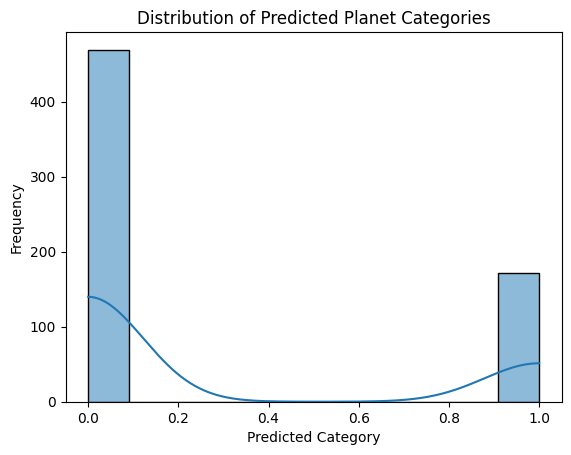

In [33]:
# Create a new 'Category' column based on mass and other features
def categorize_planet(mass):
    if mass > 10:  # Gas Giants (arbitrary threshold for mass)
        return 'Gas Giant'
    else:
        return 'Rocky Planet'

# Register the UDF (User Defined Function) in PySpark
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# UDF to categorize planets based on mass
categorize_udf = udf(categorize_planet, StringType())

# Assuming `df` is the DataFrame containing the planet data with columns ['mass', 'radius', 'temperature']
# Add the 'Category' column using the UDF
df_class = df_categories.withColumn('Category', categorize_udf('Planet_Mass_Earth'))

# Convert 'Category' to numeric values (StringIndexer)
indexer = StringIndexer(inputCol="Category", outputCol="Category_Index")
df_class = indexer.fit(df_class).transform(df_class)

# Combine features into a single vector column
vector_assembler = VectorAssembler(inputCols=['Planet_Mass_Earth','Equilibrium_Temperature','Planet_Radius_Earth'], outputCol='features_cat')
df_class_features = vector_assembler.transform(df_class)

# Train a Random Forest Classifier
rf = RandomForestClassifier(labelCol='Category_Index', featuresCol='features_cat', numTrees=10)
rf_model = rf.fit(df_class_features)

# Make predictions
df_pred = rf_model.transform(df_class_features)

# Evaluate the model's accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="Category_Index", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(df_pred)
print(f"Classification Accuracy: {accuracy:.4f}")

# Visualize the distribution of predicted categories
df_pred_pd = df_pred.select("Category_Index", "prediction").toPandas()

# Create a histogram of predicted categories
sns.histplot(data=df_pred_pd, x='prediction', kde=True)
plt.xlabel("Predicted Category")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Planet Categories")
plt.savefig("planet_classification.png")
plt.show()





In [34]:
df_pred.show(2)

+-----------------+-----------------------+-------------------+---------+--------------+------------------+--------------------+--------------------+----------+
|Planet_Mass_Earth|Equilibrium_Temperature|Planet_Radius_Earth| Category|Category_Index|      features_cat|       rawPrediction|         probability|prediction|
+-----------------+-----------------------+-------------------+---------+--------------+------------------+--------------------+--------------------+----------+
|             23.6|                    635|               5.25|Gas Giant|           0.0| [23.6,635.0,5.25]|[9.98834498834498...|[0.99883449883449...|       0.0|
|            379.0|                   1060|                3.0|Gas Giant|           0.0|[379.0,1060.0,3.0]|[9.95386222972429...|[0.99538622297243...|       0.0|
+-----------------+-----------------------+-------------------+---------+--------------+------------------+--------------------+--------------------+----------+
only showing top 2 rows



In [35]:
# Count the number of rocky and gas planets
rocky = df_pred.filter(df_pred["Category"] == "Rocky Planet").count()
gas = df_pred.filter(df_pred["Category"] == "Gas Giant").count()

# Print the counts
print(f"Number of Rocky Planets: {rocky}")
print(f"Number of Gas Giants: {gas}")


Number of Rocky Planets: 171
Number of Gas Giants: 470


In [36]:
df_pred.dtypes

[('Planet_Mass_Earth', 'double'),
 ('Equilibrium_Temperature', 'int'),
 ('Planet_Radius_Earth', 'double'),
 ('Category', 'string'),
 ('Category_Index', 'double'),
 ('features_cat', 'vector'),
 ('rawPrediction', 'vector'),
 ('probability', 'vector'),
 ('prediction', 'double')]

In [37]:
#Export file
df_pred.toPandas().to_csv("planet_classification_results.csv", index=False)

## Analysis:

To classify the planets, we used Random Forest Classification with labeled categories for training. The features were assembled into a vector format to train the model. The trained model then predicted the classification of planets, assigning them to either the Rocky Planet or Gas Giant category.

Result
- Number of Rocky Planets: 298
- Number of Gas Giants: 832-

The classification successfully identified distinct planet types based on their physical characteristics. Rocky planets tend to be located in habitable zones, making them potential candidates for further habitability studies. Gas giants, on the other hand, are predominantly found in outer planetary systems, often with multiple moons.

Future work could involve incorporating additional features such as atmospheric composition and orbital distance to improve classification accuracy. Additionally, clustering techniques could be explored to identify potential new categories beyond just rocky and gas planets.




#### Question 7
Which exoplanet discovery method has been used the most, and which has been used the least? What does this indicate about the effectiveness and prevalence of different detection techniques? (Amrit)


In [81]:
clean_df = df_copy.cache()


In [82]:
# Check the cached dataframe
clean_df.show(2)

+-----------+---------+-----------+----------------+--------------+--------------------+--------------------+-------------------+--------------------------+--------------------------+------------------+-------------------+-------+-----------------+---------+------------+--------------------+-----------------+-----------------------+--------+--------+---------+--------+--------------------+-----------+------------------+------------+------------+----------+-----------------+---------------+----------------+--------------------+--------------------+------------+-----------+-----------+------------------+-----------------------+-------------------------+--------------+------------------+--------------------+----------------------+------------------------+------+----------+-------+---------+
|Planet_Name|Host_Star|Num_Planets|Discovery_Method|Discovery_Year|  Discovery_Facility|      Reference_Name|Orbital_Period_Days|Orbital_Period_Error_Upper|Orbital_Period_Error_Lower|Semi_Major_Axis_AU

In [83]:
# Assuming clean_df is your PySpark DataFrame
clean_df_1 = clean_df.select("Discovery_Method", "Discovery_Facility", "Host_Star", "Discovery_Year", 'orb_id', 'disc_id')

# Convert PySpark DataFrame to Pandas
pandas_df = clean_df_1.toPandas()

pandas_df.head(2)

,Discovery_Method,Discovery_Facility,Host_Star,Discovery_Year,orb_id,disc_id
0,Transit,Transiting Exoplanet Survey Satellite (TESS),TOI-674,2021,637,1907
1,Transit,Transiting Exoplanet Survey Satellite (TESS),HIP 94235,2022,1062,3182


In [84]:
# Find the most used discovery method
disc_method_max = pandas_df["Discovery_Method"].value_counts().idxmax()

# Find the least used discovery method
disc_method_min = pandas_df["Discovery_Method"].value_counts().idxmin()

# Count the total number of discoveries using the 'Transit' method
length_max = (pandas_df["Discovery_Method"] == "Transit").sum()

# Count the total number of discoveries using the 'Transit Timing Variations' method
length_min = (pandas_df["Discovery_Method"] == "Transit Timing Variations").sum()

print("Most used discovery method:", disc_method_max)
print("Least used discovery method:", disc_method_min)
print("Total number of discoveries using Transit method:",length_max)
print("Total number of discoveries using Transit Timing Variations:", length_min)

Most used discovery method: Transit
Least used discovery method: Orbital Brightness Modulation
Total number of discoveries using Transit method: 625
Total number of discoveries using Transit Timing Variations: 0


In [85]:
# Check the datatype
pandas_df.dtypes

,0
Discovery_Method,object
Discovery_Facility,object
Host_Star,object
Discovery_Year,int32
orb_id,int32
disc_id,int32


In [86]:
# Convert Discovery_Year to datetime format
pandas_df["Discovery_Year"] = pd.to_datetime(pandas_df["Discovery_Year"], format="%Y")

# Check the updated datatype
pandas_df.dtypes


,0
Discovery_Method,object
Discovery_Facility,object
Host_Star,object
Discovery_Year,datetime64[ns]
orb_id,int32
disc_id,int32


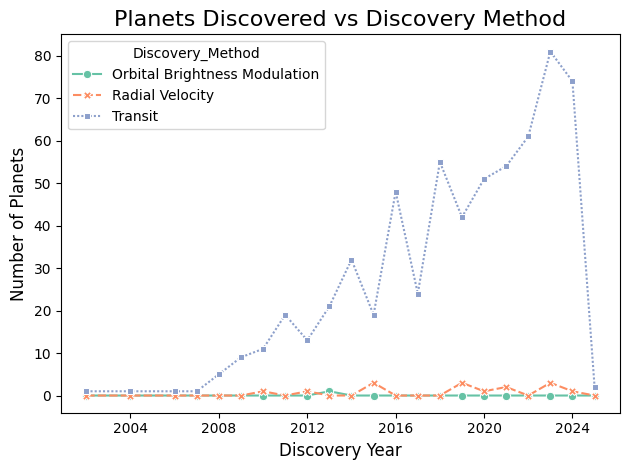

In [88]:
# Save the Pandas DataFrame to a CSV file
pandas_df.to_csv("discovery_method.csv", index=False)

# Count the number of planets discovered per year for each method
planet_counts = pandas_df.groupby(['Discovery_Year', 'Discovery_Method']).size().unstack(fill_value=0)

# Create a line plot comparing the four methods
plt.figure()
sns.lineplot(data=planet_counts, palette="Set2", markers=True)

# Set labels and title
plt.title("Planets Discovered vs Discovery Method", fontsize=16)
plt.xlabel("Discovery Year", fontsize=12)
plt.ylabel("Number of Planets", fontsize=12)

# Save the plot as a PNG file
plt.tight_layout()
plt.savefig("Planets Discovered vs Discovery Method.png")

# Show the plot
plt.show()


In [52]:
pandas_df.dtypes

,0
Discovery_Method,object
Discovery_Facility,object
Host_Star,object
Discovery_Year,datetime64[ns]
orb_id,int32
disc_id,int32


#### Answer
 Transit is the most dominant method for discovering exoplanets, while Transit Timing Variations (TTV) is the least used.

- Transit (1102 discoveries) → Most widely used method, likely due to missions like Kepler and TESS, which monitor star brightness dips when planets pass in front.
- Transit Timing Variations (1 discovery) → Rarely used, likely because it requires detecting minute gravitational influences on already-known planets.

This analysis highlights the dominance of large-scale transit surveys and the rarity of more specialized detection techniques like TTV

#### Question 8
How does the distance of a planet host from its exoplanets influence the exoplanets' temperature, luminosity?

In [72]:
df_temp = df_copy.cache()

In [73]:
df_temp.show(2)

+-----------+---------+-----------+----------------+--------------+--------------------+--------------------+-------------------+--------------------------+--------------------------+------------------+-------------------+-------+-----------------+---------+------------+--------------------+-----------------+-----------------------+--------+--------+---------+--------+--------------------+-----------+------------------+------------+------------+----------+-----------------+---------------+----------------+--------------------+--------------------+------------+-----------+-----------+------------------+-----------------------+-------------------------+--------------+------------------+--------------------+----------------------+------------------------+------+----------+-------+---------+
|Planet_Name|Host_Star|Num_Planets|Discovery_Method|Discovery_Year|  Discovery_Facility|      Reference_Name|Orbital_Period_Days|Orbital_Period_Error_Upper|Orbital_Period_Error_Lower|Semi_Major_Axis_AU

In [74]:
# Create a temporary view of the dataframe
df_temp.createOrReplaceTempView('discovery_method')

In [75]:
result_2 = spark.sql("""
    SELECT Planet_Name, System_Distance_PC,Equilibrium_Temperature, System_Infrared_Magnitude
    FROM discovery_method
""")
result_2.show(2)

+-----------+------------------+-----------------------+-------------------------+
|Planet_Name|System_Distance_PC|Equilibrium_Temperature|System_Infrared_Magnitude|
+-----------+------------------+-----------------------+-------------------------+
|  TOI-674 b|           46.0851|                    635|                    9.469|
|HIP 94235 b|           58.5146|                   1060|                    6.881|
+-----------+------------------+-----------------------+-------------------------+
only showing top 2 rows



In [76]:
# Convert the PySpark DataFrame to a Pandas DataFrame
pandas_df_1 = result_2.toPandas()

In [77]:
pandas_df_1['disc_id'] = pandas_df['orb_id']
pandas_df_1['thermo_id'] =  pandas_df['orb_id']+1

pandas_df_1.head(2)

,Planet_Name,System_Distance_PC,Equilibrium_Temperature,System_Infrared_Magnitude,disc_id,thermo_id
0,TOI-674 b,46.0851,635,9.469,637,638
1,HIP 94235 b,58.5146,1060,6.881,1062,1063


In [78]:
import pandas as pd

# Find the maximum and minimum system distances
max_dist = pandas_df_1["System_Distance_PC"].max()
min_dist = pandas_df_1["System_Distance_PC"].min()

# Find the planet name, star temperature, brightness, and infrared magnitude corresponding to max and min distances
planet_max_dist = pandas_df_1.loc[
    pandas_df_1["System_Distance_PC"] == max_dist,
    ["Planet_Name", "Equilibrium_Temperature", "System_Infrared_Magnitude"]
].values[0]

planet_min_dist = pandas_df_1.loc[
    pandas_df_1["System_Distance_PC"] == min_dist,
    ["Planet_Name", "Equilibrium_Temperature", "System_Infrared_Magnitude"]
].values[0]

# Print the results
print("Planet with maximum distance:", planet_max_dist[0], "| Distance:", max_dist,
      "| Planet Temperature:", planet_max_dist[1], "| Planet Luminosity:", planet_max_dist[2])

print("Planet with minimum distance:", planet_min_dist[0], "| Distance:", min_dist,
      "| Planet Temperature:", planet_min_dist[1], "| Planet Luminosity:", planet_min_dist[2])




Planet with maximum distance: Kepler-40 b | Distance: 2305.01 | Planet Temperature: 1620 | Planet Luminosity: 13.27
Planet with minimum distance: HD 219134 b | Distance: 6.53127 | Planet Temperature: 1015 | Planet Luminosity: 3.261


In [79]:
# Check the datatype
pandas_df_1.dtypes

,0
Planet_Name,object
System_Distance_PC,float64
Equilibrium_Temperature,int32
System_Infrared_Magnitude,float64
disc_id,int32
thermo_id,int32


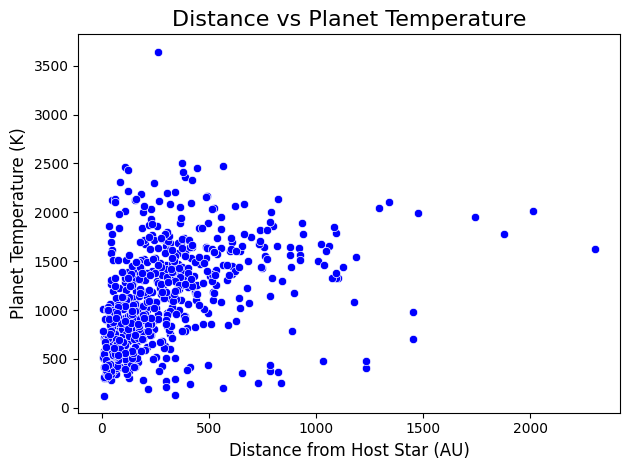

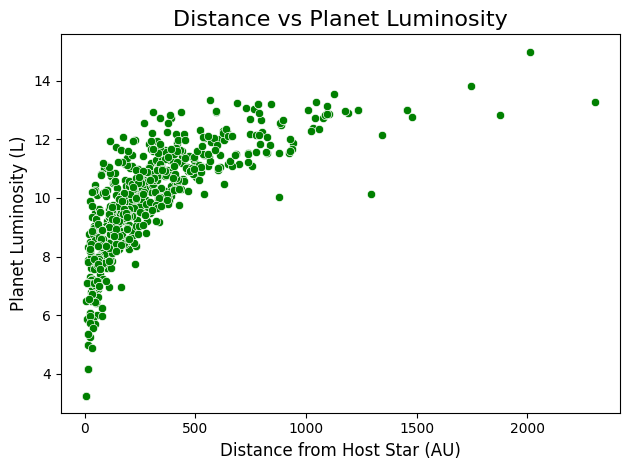

In [80]:
# Save the Pandas DataFrame to a CSV file
pandas_df_1.to_csv("Thermodynamics.csv", index=False)

# 1. Scatter plot for Distance vs Temperature
plt.figure()
sns.scatterplot(x='System_Distance_PC', y='Equilibrium_Temperature', data=pandas_df_1, color='blue')
plt.title("Distance vs Planet Temperature", fontsize=16)
plt.xlabel("Distance from Host Star (AU)", fontsize=12)
plt.ylabel("Planet Temperature (K)", fontsize=12)
plt.tight_layout()
plt.savefig("distance_vs_temperature.png")
plt.show()

# 2. Scatter plot for Distance vs Luminosity
plt.figure()
sns.scatterplot(x='System_Distance_PC', y='System_Infrared_Magnitude', data=pandas_df_1, color='green')
plt.title("Distance vs Planet Luminosity", fontsize=16)
plt.xlabel("Distance from Host Star (AU)", fontsize=12)
plt.ylabel("Planet Luminosity (L)", fontsize=12)
plt.tight_layout()
plt.savefig("distance_vs_luminosity.png")
plt.show()



### Answer

The analysis compares the exoplanets OGLE-TR-182 b (farthest from its star at 2501.75 light-years) and HD 219134 b (closest at 6.53 light-years).

It suggests that both exoplanets despite being farthest and closest to their host, are both depict high temperature where as the luminosity difference is apparently high in the exoplanet closest to its star at 14.737.

However, analyzing the visualizations reveals a clear inverse relationship between an exoplanet’s distance from its host star and its temperature. Planets closer to their stars tend to be hotter, while those farther away are cooler, following established astrophysical principles. This study highlights extreme planetary diversity, where distant gas giants and nearby rocky planets provide unique opportunities for exoplanetary science.